# Transfer Learning  with TensorFlow Part 2: Fine-Tuning

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Creating helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-28 10:21:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-12-28 10:21:51 (14.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.application`

In [2]:
# Get 10% of training data of 10 classes of Food101
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

--2023-12-29 05:49:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  70.0MB/s    in 2.3s    

2023-12-29 05:49:40 (70.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import zipfile

filename = "10_food_classes_10_percent.zip"
zip_ref = zipfile.ZipFile(filename, "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
import os

dir_path = "./10_food_classes_10_percent"
for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in './10_food_classes_10_percent'.
There are 10 directories and 0 images in './10_food_classes_10_percent/test'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in './10_foo

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[2.43811234e+02 1.00811226e+02 4.81122398e+00]
   [2.42790817e+02 9.97908173e+01 3.79081702e+00]
   [2.47224487e+02 1.03010208e+02 7.65306091e+00]
   ...
   [1.67760284e+02 7.36072388e+01 3.71787148e+01]
   [1.58739807e+02 6.90255814e+01 3.43572083e+01]
   [1.58311050e+02 7.46682281e+01 4.06682281e+01]]

  [[2.47091843e+02 1.04091843e+02 8.09183788e+00]
   [2.41270401e+02 9.82704086e+01 2.27040720e+00]
   [2.46168365e+02 1.02168365e+02 6.16836643e+00]
   ...
   [1.69086731e+02 7.69591827e+01 3.75867767e+01]
   [1.64066360e+02 7.61480408e+01 3.84184570e+01]
   [1.66234558e+02 8.29489059e+01 4.56631584e+01]]

  [[2.40632660e+02 9.86326523e+01 7.85714149e-01]
   [2.45984695e+02 1.03984695e+02 5.98469496e+00]
   [2.48357147e+02 1.04357140e+02 8.14285660e+00]
   ...
   [1.72234711e+02 8.29745483e+01 3.85918922e+01]
   [1.66372406e+02 7.96734772e+01 3.61581535e+01]
   [1.60214142e+02 8.02856827e+01 3.44999313e+01]]

  ...

  [[1.22199005e+02 3.27704735e+01 2.98473883e+00]
   [1

In [43]:
# Create TensorBoard callback (functionized bevause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to : {log_dir}")
    return tensorboard_callback

In [45]:

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [ ]:
# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
import os
model_dir = "models/05_models/"

os.makedirs(model_dir, exist_ok=True)

model_0.save(os.path.join(model_dir, "00_model.keras"))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./transfer_learning

In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 144s 2s/step - loss: 0.5714 - accuracy: 0.8584


[0.5714187622070312, 0.8583999872207642]

In [ ]:
base_model.summary()

In [ ]:
model_0.summary()

In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid();

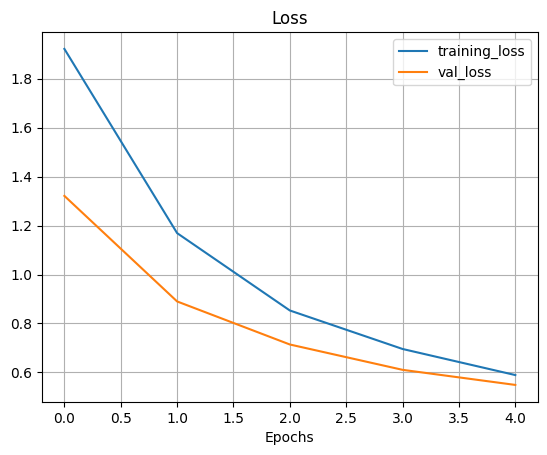

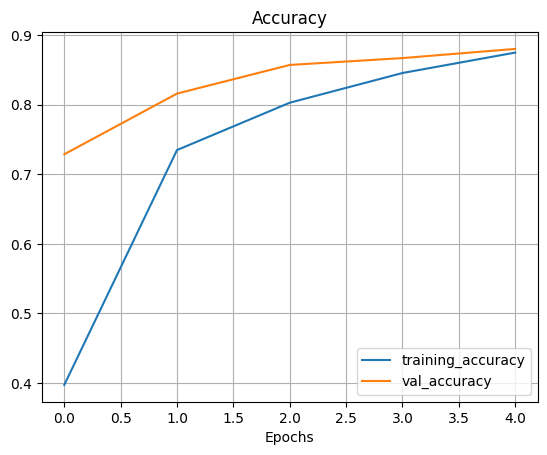

In [ ]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from trained model

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

**Practice:** Try to do the same with the above two cels but this time use `GlobalMaxPool2D` ... and see what happens.

In [ ]:
global_maxpool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_maxpool_tensor}")

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]


In [ ]:
global_maxpool_tensor.shape

TensorShape([1, 3])

## Running a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

## Getting and preprocessing data for model_1

In [13]:
# Download and unzip data - preprocessed from Food101
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"

import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-29 05:50:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   238MB/s    in 0.5s    

2023-12-29 05:50:38 (238 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [14]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [15]:
dir_path = "10_food_classes_1_percent"
for dirpath, dirnames, filenames in os.walk(dir_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 2 directories and 0 images in '10_food_classes_1_percent
There are 10 directories and 0 images in '10_food_classes_1_percent/test
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger
There are 10 directori

In [16]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)  # default
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.prprocessing()`


* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than on CPU.
* Image data augmentation only happens during training, so  we can still export our whole model and use it elsewhere

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create daa augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255)  # Keep for models like ResNet50V2 but EfficientNet's having rescaling build-in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

Text(0.5, 1.0, 'Augmented random image ramen')

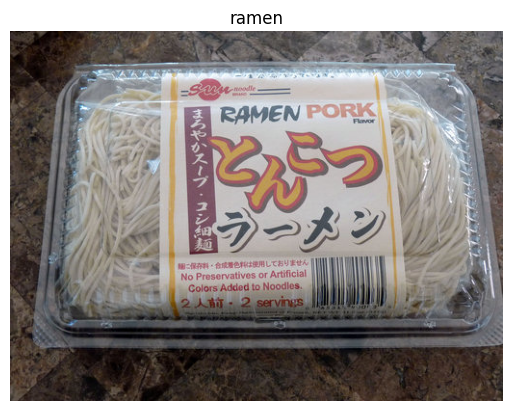

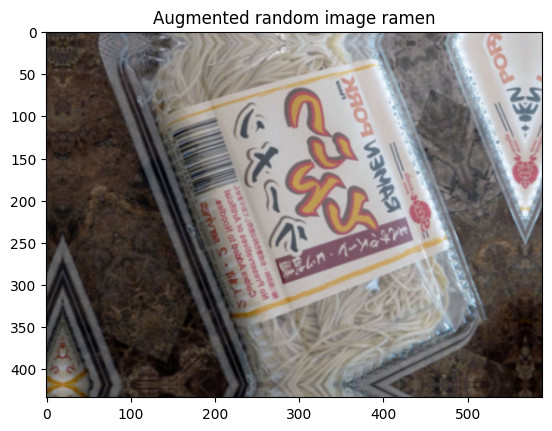

In [18]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image {target_class}")

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_shape")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data_1_percent,
            validation_steps=int(0.25 * len(test_data_1_percent)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to : transfer_learning/1_percent_data_aug/20231228-161008
Epoch 1/5
3/3 [==============================] - 98s 44s/step - loss: 2.4446 - accuracy: 0.0714 - val_loss: 2.2119 - val_accuracy: 0.1941
Epoch 2/5
3/3 [==============================] - 90s 43s/step - loss: 2.1901 - accuracy: 0.2429 - val_loss: 2.0780 - val_accuracy: 0.2895
Epoch 3/5
3/3 [==============================] - 60s 29s/step - loss: 1.9439 - accuracy: 0.3714 - val_loss: 1.9836 - val_accuracy: 0.3635
Epoch 4/5
3/3 [==============================] - 46s 22s/step - loss: 1.8133 - accuracy: 0.4571 - val_loss: 1.8780 - val_accuracy: 0.4227
Epoch 5/5
3/3 [==============================] - 47s 22s/step - loss: 1.5980 - accuracy: 0.6286 - val_loss: 1.7804 - val_accuracy: 0.4836


In [ ]:
# Check iut a model summary
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 168s 2s/step - loss: 1.7897 - accuracy: 0.4828


[1.7897396087646484, 0.4828000068664551]

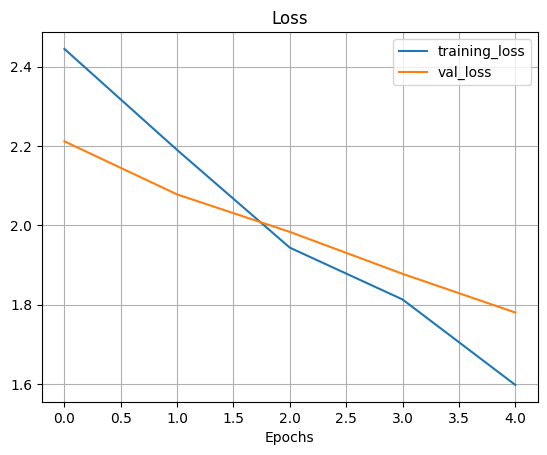

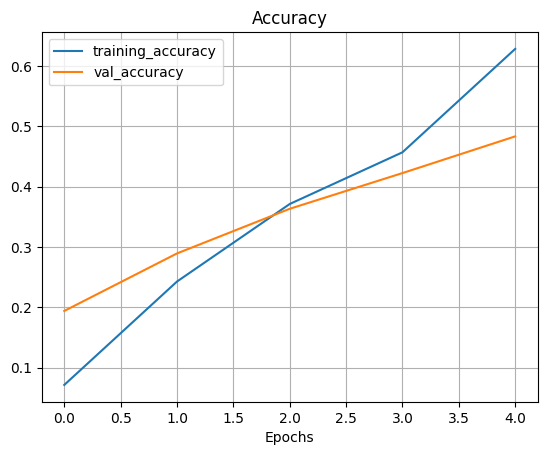

In [ ]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of the data with data augmentation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      ], name="data_augmentation")

In [65]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_shape")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


### Createing a ModelCheckpoint callback

In [66]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weghts/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weight_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",  # save every epoch
                                                         verbose=1)

### Fit model 2 passing in  the ModelCheckpoint callback

In [67]:
initial_epochs = 5

In [68]:
# Fit the model saving checkpoints every epoch
history_10_percent_aug = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(0.25 * len(test_data_10_percent)),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name="10_percent_data_aug"),
                                         checkpoint_callback])

Saving TensorBoard log files to : transfer_learning/10_percent_data_aug/20231229-081041
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9588 - accuracy: 0.3773
Epoch 1: saving model to ten_percent_model_checkpoints_weghts/checkpoint.ckpt
24/24 [==============================] - 191s 8s/step - loss: 1.9588 - accuracy: 0.3773 - val_loss: 1.3863 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2809 - accuracy: 0.6773
Epoch 2: saving model to ten_percent_model_checkpoints_weghts/checkpoint.ckpt
24/24 [==============================] - 192s 8s/step - loss: 1.2809 - accuracy: 0.6773 - val_loss: 0.9508 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9944 - accuracy: 0.7560
Epoch 3: saving model to ten_percent_model_checkpoints_weghts/checkpoint.ckpt
24/24 [==============================] - 201s 8s/step - loss: 0.9944 - accuracy: 0.7560 - val_loss: 0.7636 - val_accuracy: 0.8240
Epoch 4/5

In [69]:
import pickle

with open('history_10_percent_aug.pkl', 'wb') as file:
  pickle.dump(history_10_percent_aug.history, file)

In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 130s 2s/step - loss: 0.5714 - accuracy: 0.8584


[0.5714185833930969, 0.8583999872207642]

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 171s 2s/step - loss: 0.4860 - accuracy: 0.8568


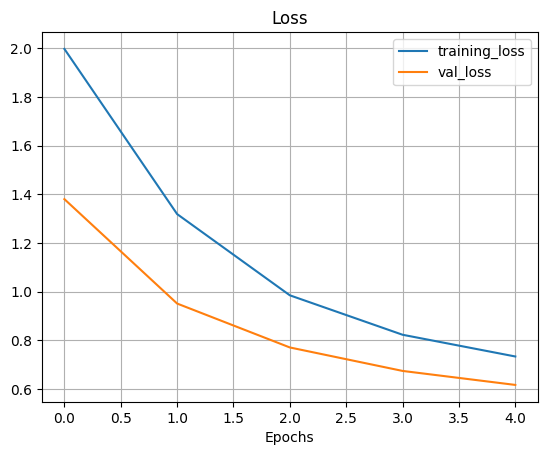

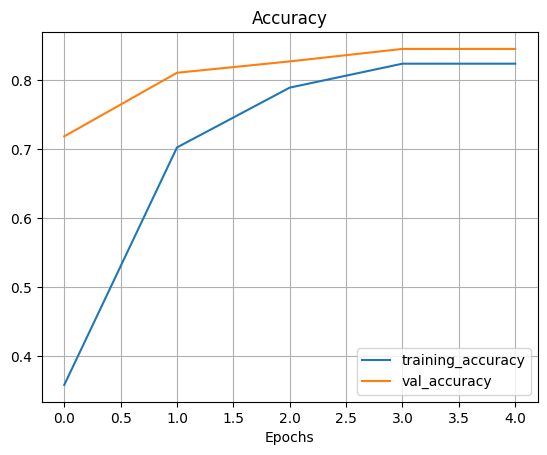

In [ ]:
plot_loss_curves(history_10_percent_aug)

### Loading in checkpointed weights

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 173s 2s/step - loss: 0.4860 - accuracy: 0.8568


In [ ]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
# Check to see if loaded model results  are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.49011612e-07 0.00000000e+00]


In [ ]:
model_0.save('model_0.keras')

In [ ]:
model_1.save('model_1.keras')

In [ ]:
model_2.save('model_2.keras')

In [19]:
from tensorflow.keras.models import load_model

model_0_loaded = load_model('model_0.keras')
model_1_loaded = load_model('model_1.keras')
model_2_loaded = load_model('model_2.keras')

## Model 3: Fine-tuning an existing model on 10% of the data

In [37]:
model_2_base_model = model_2_loaded.layers[2]
model_2_base_model.name

'efficientnetb0'

In [38]:

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_16 True
1 rescaling_29 False
2 normalization_15 False
3 rescaling_30 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze F

In [41]:
# How many trainable variables are in our base model?
print(len(model_2_base_model.trainable_variables))

0


In [51]:

# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2_loaded.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [54]:
print(len(model_2_base_model.layers))

238


In [58]:
print(len(model_2_base_model.trainable_variables))

10


In [ ]:
import pickle

with open('history_10_percent_aug.pkl', 'rb') as file:
  history_10_percent_aug_loaded = pickle.load(file)

In [63]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same sa model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2_loaded.fit(train_data_10_percent,
                                                            epochs=fine_tune_epochs,
                                                            validation_data=test_data_10_percent,
                                                            validation_steps=int(0.25 * len(test_data_10_percent)),
                                                            initial_epoch=history_10_percent_aug.epoch[-1],  # start trianing from previous last epoch
                                                            callabacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                                     experiment_name="10_percent_fine_tune_last_10_percent")])

NameError: ignored